In [1]:
import tensorflow as tf
from tensorflow. keras import models, layers 
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillageTomato',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )
    

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[6 6 7 4 7 7 2 2 4 6 8 2 7 4 7 2 5 1 5 0 4 9 7 6 3 0 5 0 1 2 0 2]


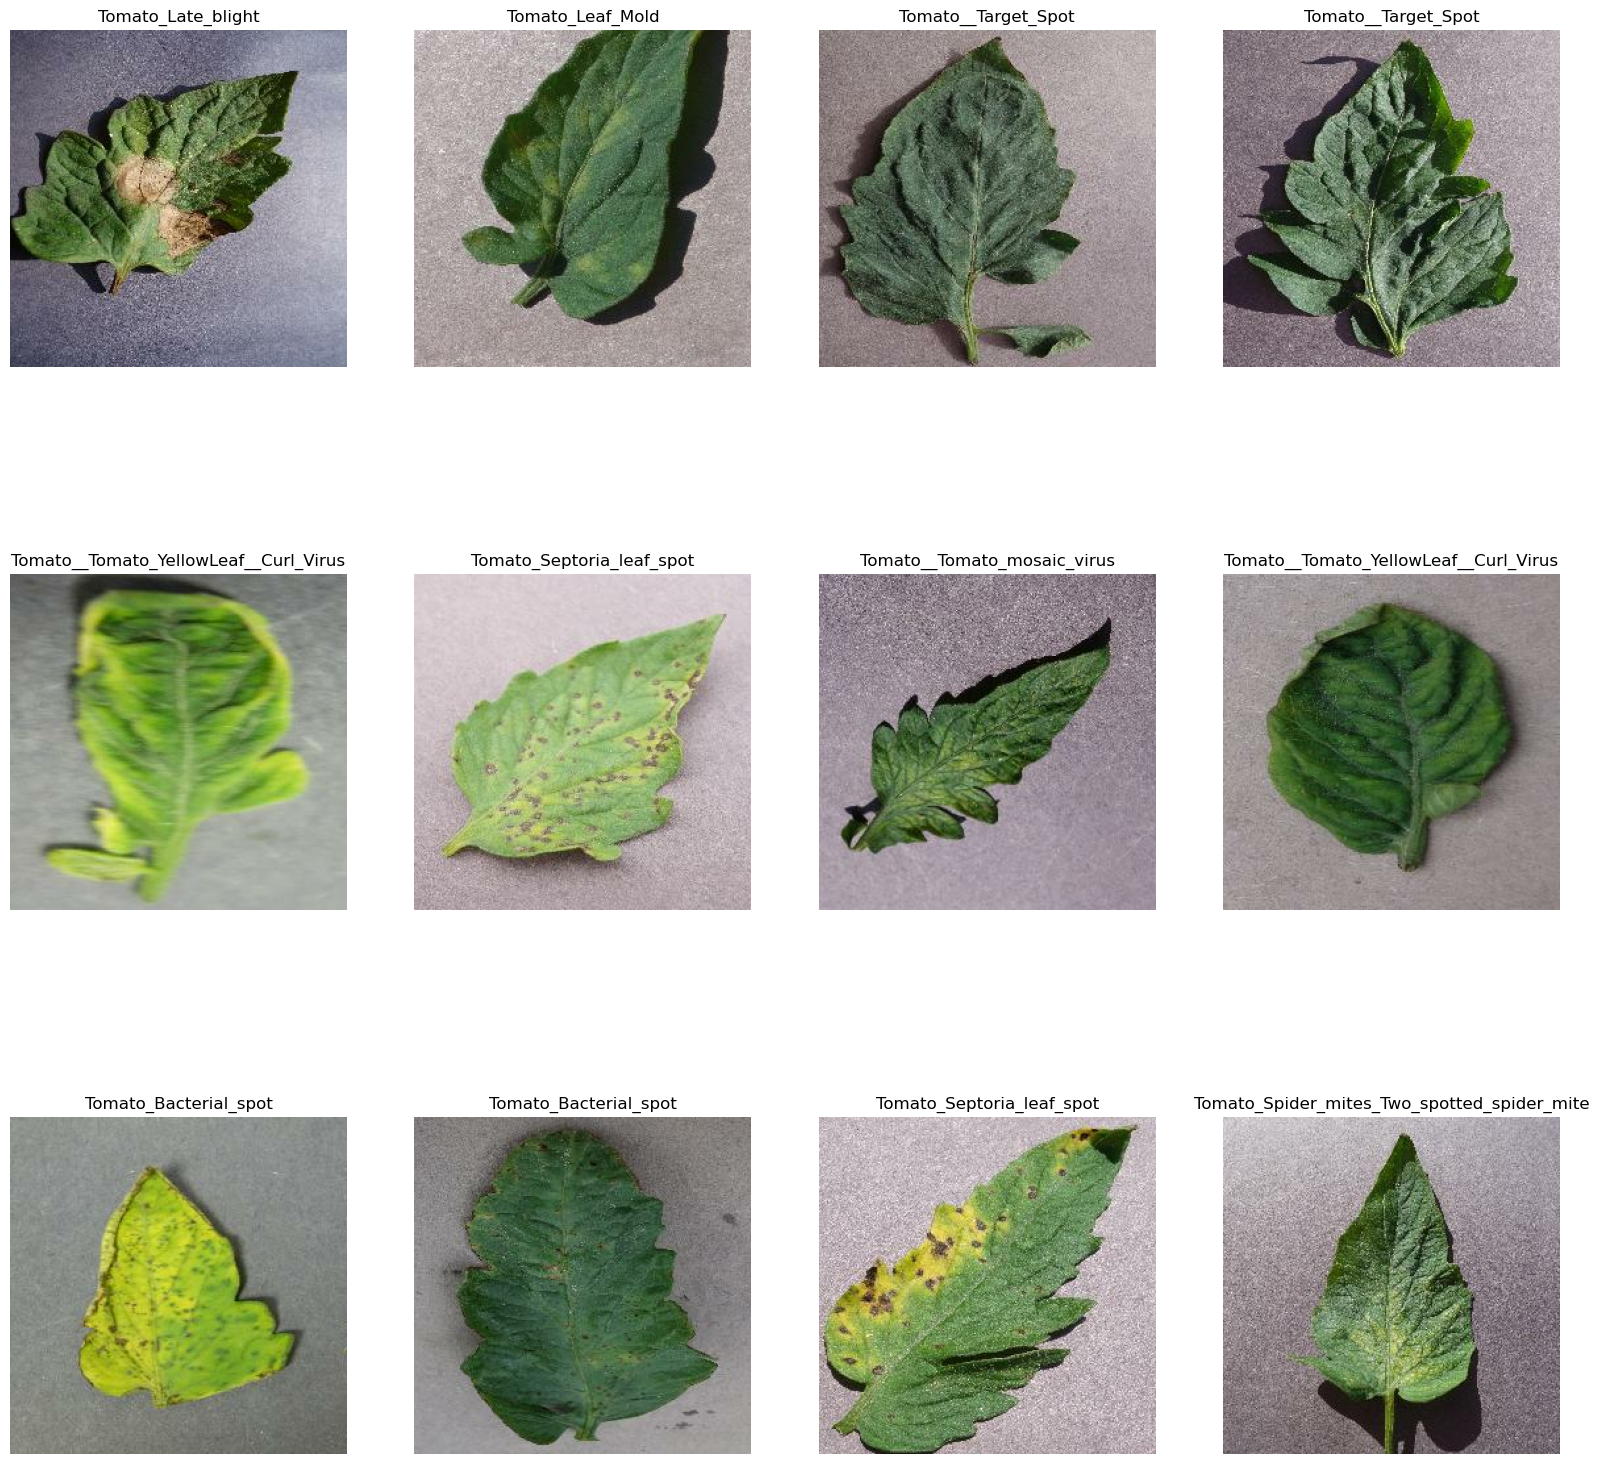

In [9]:
plt.figure(figsize = (20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#80% ==>training
#20% ==>10% validation, 10% test

In [11]:
train_size = 0.8
test_size = 0.1
val_size = 0.1
shuffle_size = 10000

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds. take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    print('It worked')
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset,train_size,val_size,test_size,shuffle =True,)

It worked


In [14]:
print(len(train_ds),len(val_ds),len(test_ds))

400 50 51


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing (IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling (1.0/255)
    ])

In [17]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip ("horizontal_and_vertical"),
layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10  

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 128)        

In [24]:
model. compile(
    optimizer= 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
model.fit(
 train_ds,
 epochs = 30,
 batch_size = BATCH_SIZE,
 verbose = 1,
 validation_data = val_ds,
)

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 1.4990 - accuracy: 0.4759

2024-05-10 19:54:55.467878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 385 of 10000
2024-05-10 19:55:02.167284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-05-10 19:55:02.652482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - 477s 1s/step - loss: 1.4990 - accuracy: 0.4759 - val_loss: 1.1227 - val_accuracy: 0.6206
Epoch 2/30
400/400 [==============================] - 475s 1s/step - loss: 0.8284 - accuracy: 0.7102 - val_loss: 0.7224 - val_accuracy: 0.7494
Epoch 3/30
400/400 [==============================] - 515s 1s/step - loss: 0.6901 - accuracy: 0.7652 - val_loss: 0.7016 - val_accuracy: 0.7844
Epoch 4/30
400/400 [==============================] - 486s 1s/step - loss: 0.5565 - accuracy: 0.8104 - val_loss: 0.5674 - val_accuracy: 0.8275
Epoch 5/30
400/400 [==============================] - 468s 1s/step - loss: 0.5102 - accuracy: 0.8277 - val_loss: 0.4083 - val_accuracy: 0.8450
Epoch 6/30
400/400 [==============================] - 505s 1s/step - loss: 0.4163 - accuracy: 0.8587 - val_loss: 0.4850 - val_accuracy: 0.8400
Epoch 7/30
400/400 [==============================] - 496s 1s/step - loss: 0.3849 - accuracy: 0.8706 - val_loss: 0.6770 - val_accuracy: 0.7887
Epoch 8/30

In [27]:
scores = model.evaluate(test_ds)

2024-05-11 00:25:31.941107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 411 of 10000
2024-05-11 00:25:37.372341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-05-11 00:25:37.974470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


51/51 [==============================] - 45s 543ms/step - loss: 0.2238 - accuracy: 0.9332


In [31]:
history

import tensorflow as tf
from tensorflow. keras import models, layers 
import matplotlib.pyplot as plt
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )
class_names = dataset.class_names
class_names
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#80% ==>training
#20% ==>10% validation, 10% test
train_size = 0.8
test_size = 0.1
val_size = 0.1
shuffle_size = 10000
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,):
    ds_size = len(ds)
    i

In [33]:
history.params()

NameError: name 'history' is not defined

First image to predict:
1/1 [==============================] - 1s 624ms/step


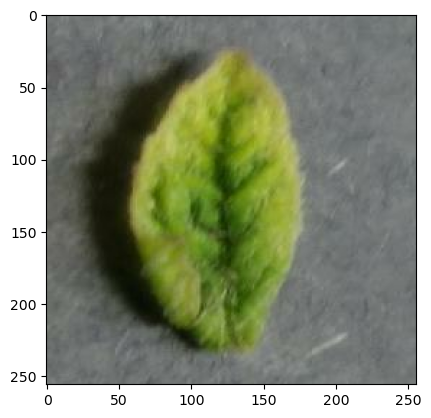

First image's actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


In [29]:
import numpy as np 

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("First image to predict:")
    batch_prediction = model.predict(images_batch)
    plt.imshow(first_image)
    plt.show()

    
    print("First image's actual label:", class_names[first_label.numpy()])
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 30ms/step


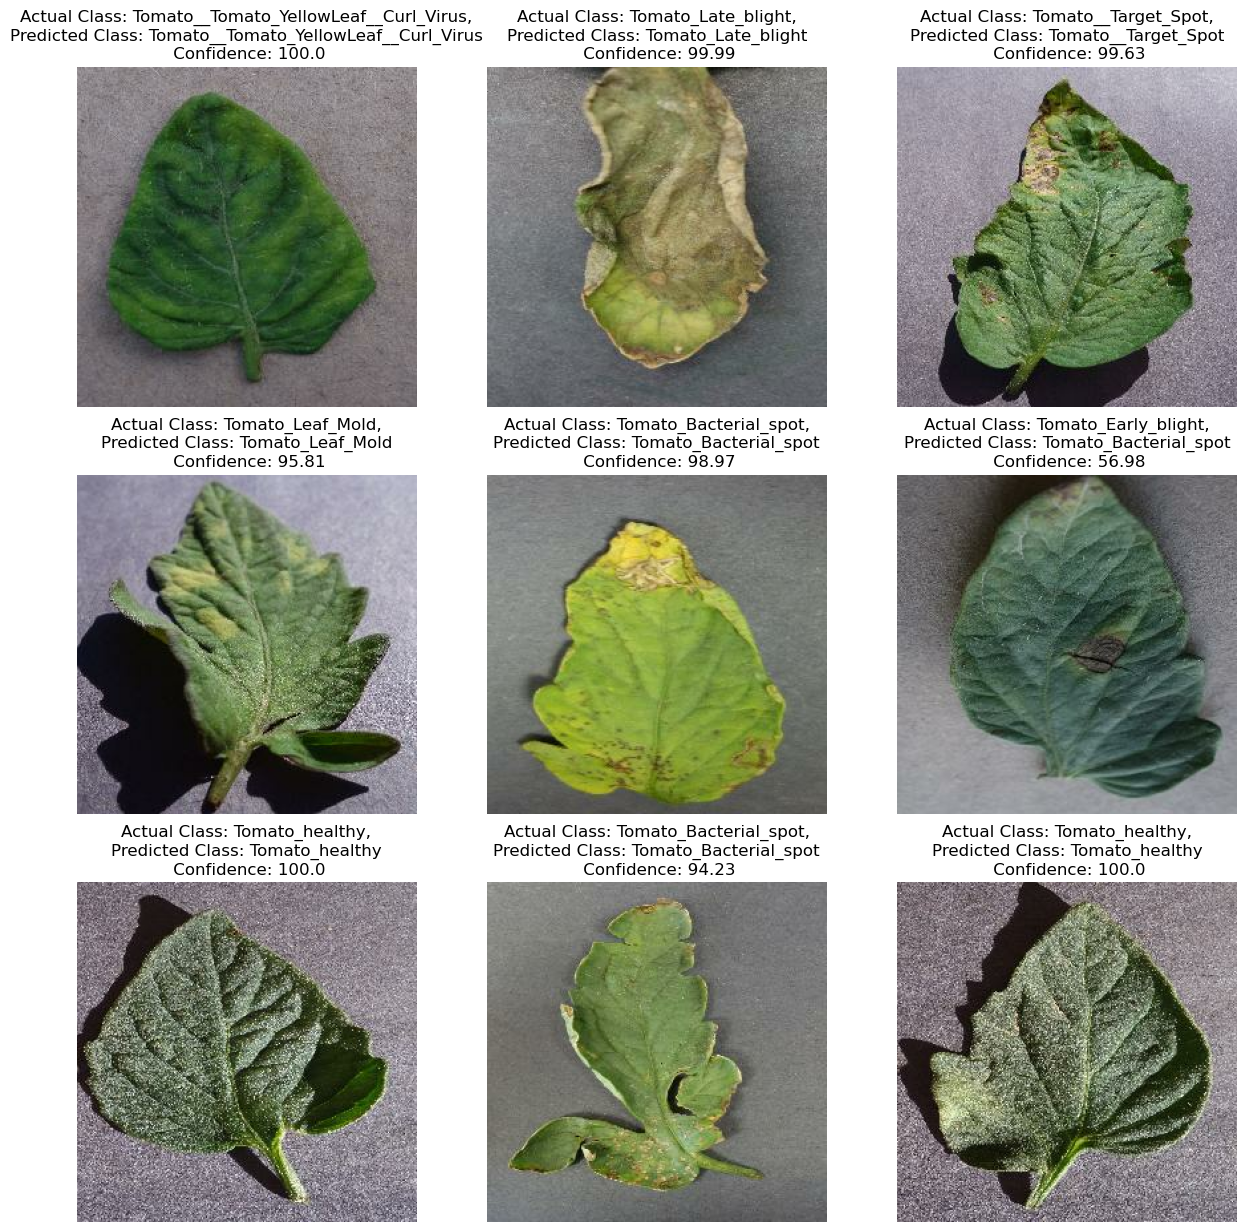

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual Class: {actual_class},\nPredicted Class: {predicted_class}\n Confidence: {confidence}')

        plt.axis("off")


In [47]:
model_version = 'tomato' + str(31) + '.h5'
print(model_version)
model.save(f'models/{model_version}')

tomato12.h5


TensorFlow version: 2.15.0
